# ***Coding Neural Network - Forward Propagation and Backpropagation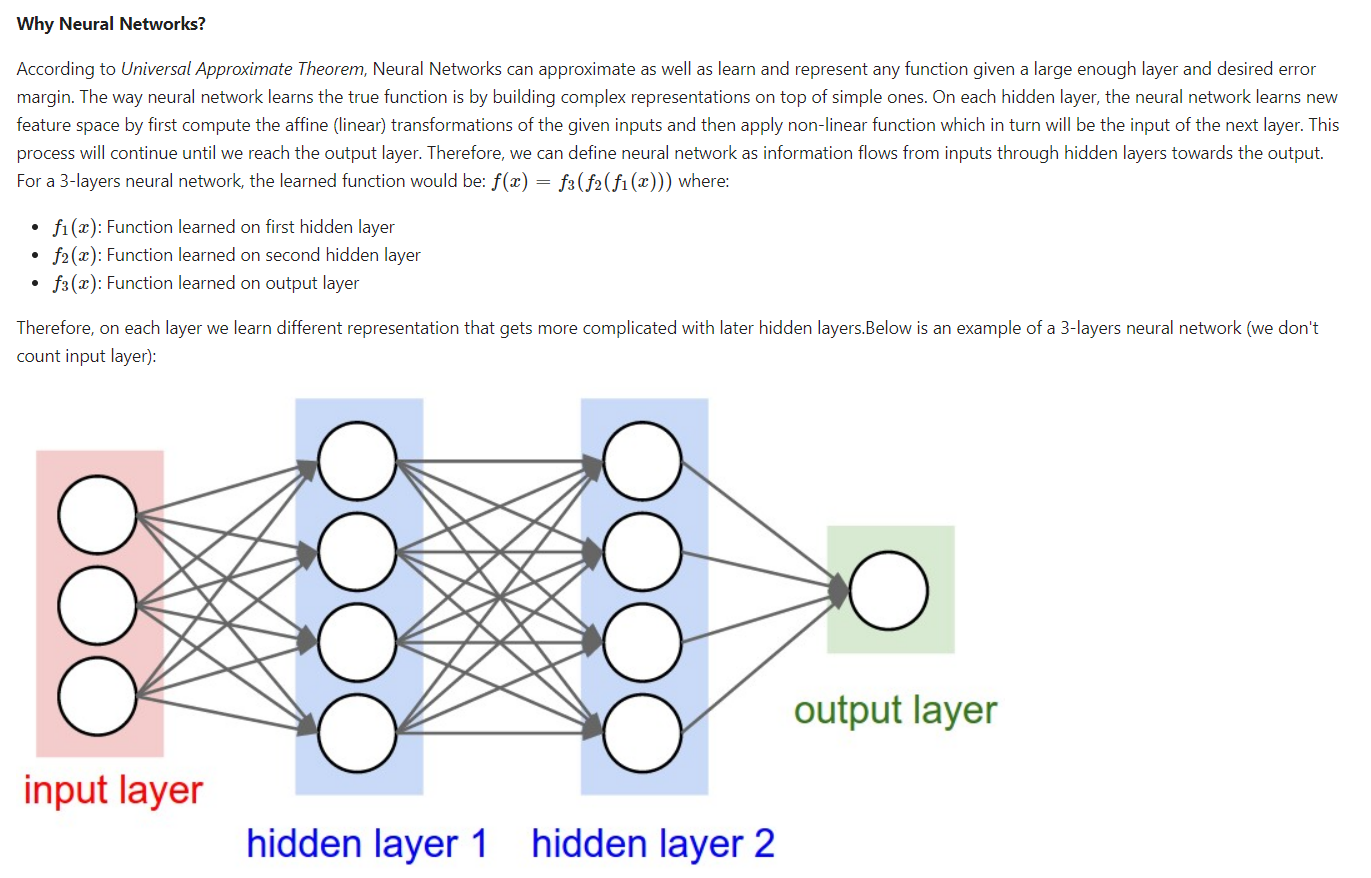***

<p>For example, computers can't understand images directly and don't know what to do with pixels data. However, a neural network can build a simple representation of the image in the early hidden layers that identifies edges. Given the first hidden layer output, it can learn corners and contours. Given the second hidden layer, it can learn parts such as nose. Finally, it can learn the object identity.

Since truth is never linear and representation is very critical to the performance of a machine learning algorithm, neural network can help us build very complex models and leave it to the algorithm to learn such representations without worrying about feature engineering that takes practitioners very long time and effort to curate a good representation.

 <b style="color:purple">The notebook has two parts:
<ol>
  <li>[Coding the neural network](#Coding the NN): This entails writing all the helper functions that would allow us to implement a multi-layer neural network. While doing so, I'll explain the theoretical parts whenever possible and give some advices on implementations. </li>
    <br>
  <li> Application: We'll implement the neural network we coded in the first part on image recognition problem to see if the network we built will be able to detect the number on the image and see if it is working :)</li>

</ol>




In [ ]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

<h1 style="color:purple">I. Coding The Neural Network</h1>

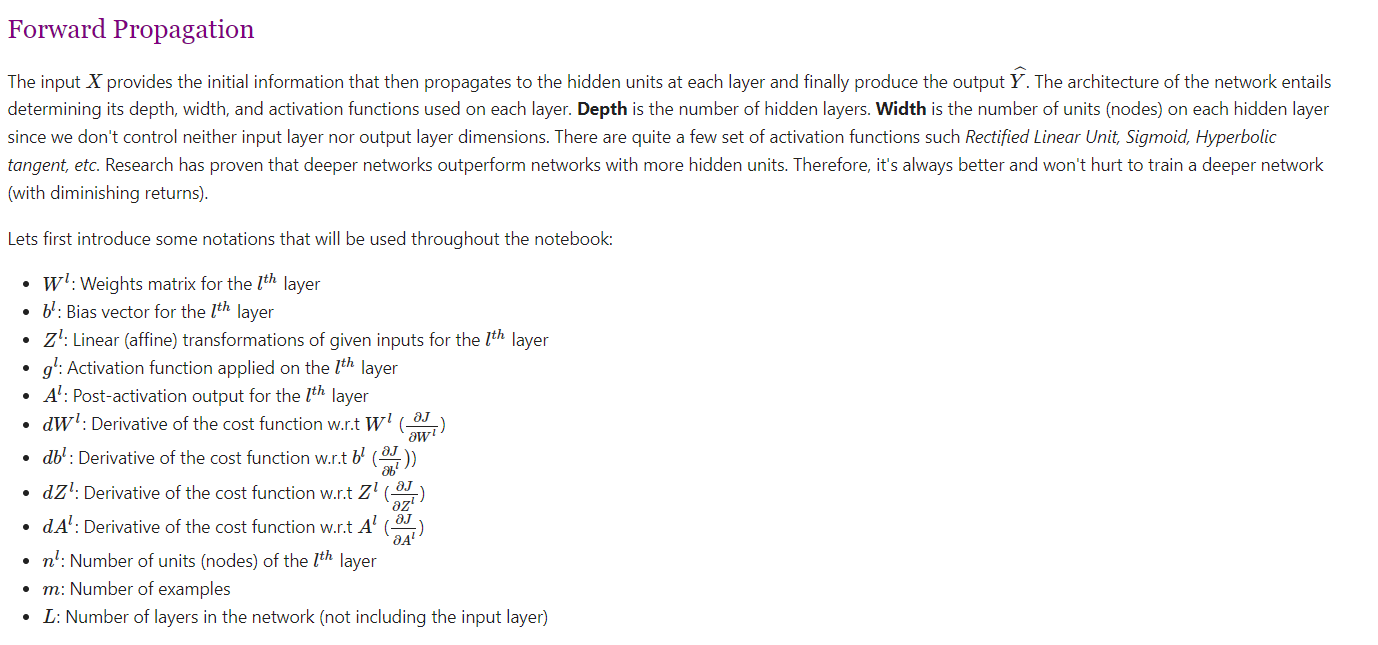

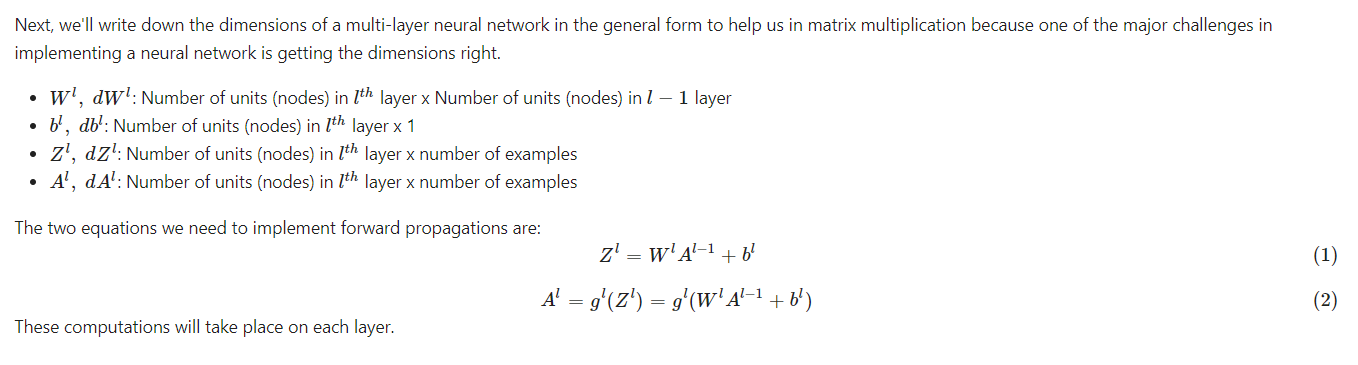

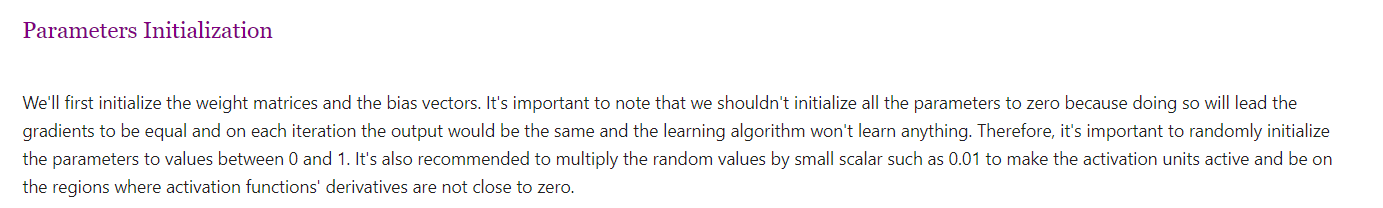

In [ ]:
# Initialize parameters
def initialise_parameters(layers_dims):
  """
    Initialize parameters dictionary.

    Weight matrices will be initialized to random values from uniform normal
    distribution.
    bias vectors will be initialized to zeros.

    Arguments
    ---------
    layers_dims : list or array-like
        dimensions of each layer in the network.

    Returns
    -------
    parameters : dict
        weight matrix and the bias vector for each layer.
    """
  np.random.seed(1)
  l=len(layers_dims)
  parameters={}

  for i in range(1,l):

    parameters["W"+str(i)]=np.random.rand(layers_dims[i-1],layers_dims[i])*0.01
    parameters["b"+str(i)]=np.zeros((1, layers_dims[i]))

    assert parameters["W" + str(i)].shape == (
            layers_dims[i-1], layers_dims[i])
    assert parameters["b" + str(i)].shape == (1,layers_dims[i])

  return parameters

<h3 style="color:purple">Activation Functions</h3>

<p>There is no definitive guide for which activation function works best on specific problems. 
It's a trial and error process where one should try different set of functions and see which one works best on the problem at hand. 
We'll cover 2 of the most commonly used activation functions: - </p>

$$ (Sigmoid)** : \sigma(z) = \frac{1}{1 + e^{-z}} $$ It's recommended to be used only on the output layer so that we can easily interpret the output as probabilities since it has restricted output between 0 and 1. One of the main disadvantages for using sigmoid function on hidden layers is that the gradient is very close to zero over a large portion of its domain which makes it slow and harder for the learning algorithm to learn.


 **Rectified Linear Unit$$ (ReLU)**: g(z)=max{(0,z)}$$
. The models that are close to linear are easy to optimize. Since ReLU shares a lot of the properties of linear functions, it tends to work well on most of the problems. The only issue is that the derivative is not defined at z=0
, which we can overcome by assigning the derivative to 0 at z=0
. However, this means that for z≤0
 the gradient is zero and again can't learn. -

If you're not sure which activation function to choose, start with ReLU.

In [ ]:
# Define activation functions that will be used in forward propagation
def sigmoid(Z):
  """
    Computes the sigmoid of Z element-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    """

  A=1/(1+np.exp(-Z))
  return A

def ReLu(Z):
  """
    Computes the Rectified Linear Unit (ReLU) element-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
  """

  A=np.maximum(0,Z)
  return A

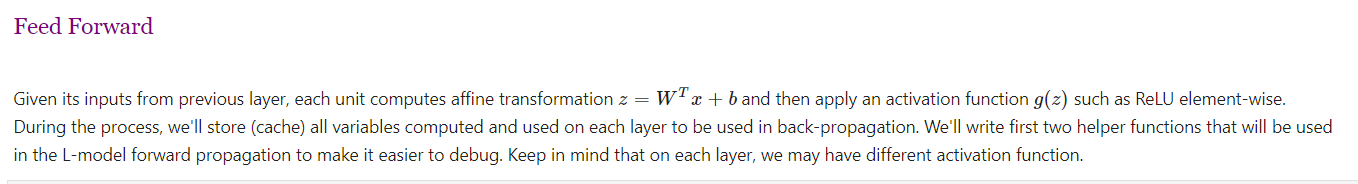

In [ ]:
def linear_forward(A_prev,W,b):

  """
    Computes affine transformation of the input.

    Arguments
    ---------
    A_prev : 2d-array
        activations output from previous layer.
    W : 2d-array
        weight matrix, shape: size of current layer x size of previuos layer.
    b : 2d-array
        bias vector, shape: size of current layer x 1.

    Returns
    -------
    Z : 2d-array
        affine transformation output.
  """
  Z=np.matmul(A_prev,W)+b

  return Z

def linear_activation_forward(A_prev,W,b,hidden_layers_activation_fn):
  """
    Computes post-activation output using non-linear activation function.

    Arguments
    ---------
    A_prev : 2d-array
        activations output from previous layer.
    W : 2d-array
        weight matrix, shape: size of current layer x size of previuos layer.
    b : 2d-array
        bias vector, shape: size of current layer x 1.
    activation_fn : str
        non-linear activation function to be used: "sigmoid", "tanh", "relu".

    Returns
    -------
    A : 2d-array
        output of the activation function.
    cache : tuple
        stores linear_cache and activation_cache. ((A_prev, W, b), Z) to be used in backpropagation.
  """
  Z=linear_forward(A_prev,W,b)

  A=hidden_layers_activation_fn(Z)

  cache=((A_prev,W,b),Z)
  # print("linear_cache:",A_prev,W,b)
  # print("Activation Cache: ",Z)

  return A,cache


def L_model_forward(X,parameters,hidden_layers_activation_fn):
  """
    Computes the output layer through looping over all units in topological
    order.

    Arguments
    ---------
    X : 2d-array
        input matrix of shape input_size x training_examples.
    parameters : dict
        contains all the weight matrices and bias vectors for all layers.
    hidden_layers_activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    AL : 2d-array
        probability vector of shape 1 x training_examples.
    caches : list
        that contains L tuples where each layer has: A_prev, W, b, Z.
  """

  l=len(parameters) // 2
  A=X

  caches=[]
  for i in range(1,l):
    A_prev=A
    A, cache = linear_activation_forward(A_prev, parameters['W' + str(i)], parameters['b' + str(i)], hidden_layers_activation_fn)

    caches.append(cache)

  A_prev=A
  AL, cache=linear_activation_forward(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],sigmoid)
  caches.append(cache)

  return AL,caches

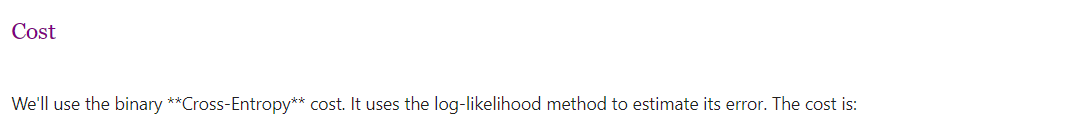

$$J(W,b) = -\frac{1}{m}\sum_{i=1}^{m} \sum_{j=1}^{n} \left( y_{ij} \log(\hat{y}_{ij}) + (1 - y_{ij}) \log(1 - \hat{y}_{ij}) \right)
$$

In [ ]:
# Compute cross-entropy cost
def compute_cost(AL,y):
  """
    Computes the binary Cross-Entropy cost.

    Arguments
    ---------
    AL : 2d-array
        probability vector of shape 1 x training_examples.
    y : 2d-array
        true "label" vector.

    Returns
    -------
    cost : float
        binary cross-entropy cost.
  """
  m=y.shape[0]
  cost=np.sum(np.multiply(y,np.log(AL))+np.multiply(1-y,np.log(1-AL)))
  cost=-1*cost/m
  return cost

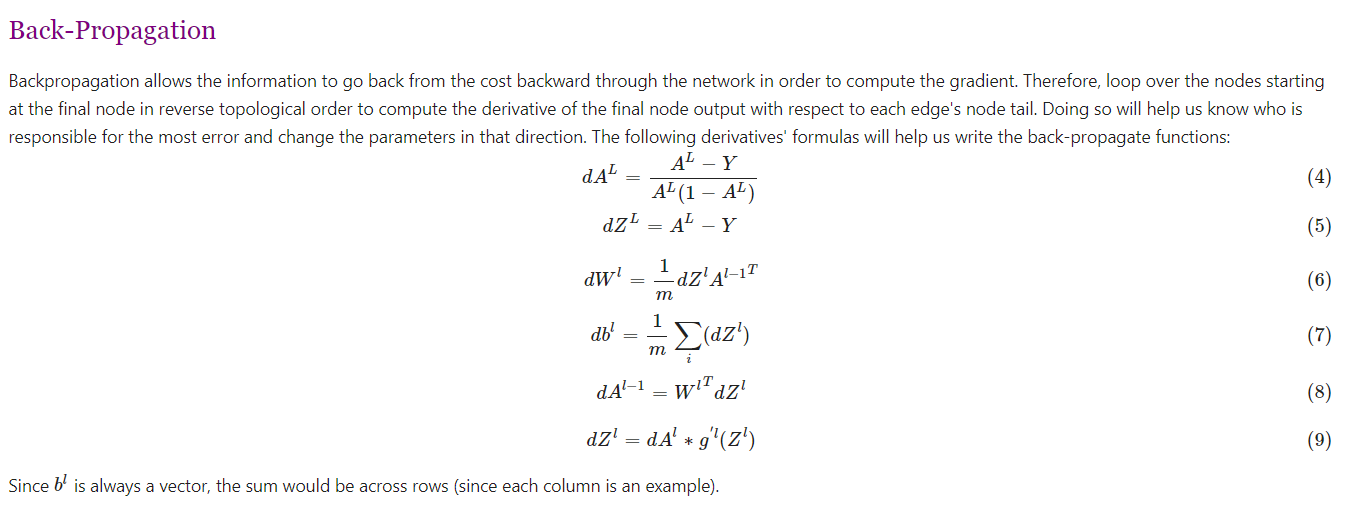

In [ ]:
def sigmoid_gradient(dA,Z):
  """
    Computes the gradient of sigmoid output w.r.t input Z.

    Arguments
    ---------
    dA : 2d-array
        post-activation gradient, of any shape.
    Z : 2d-array
        input used for the activation fn on this layer.

    Returns
    -------
    dZ : 2d-array
        gradient of the cost with respect to Z.
  """
  A=sigmoid(Z)
  x=np.multiply(A,1-A)
  dZ=np.multiply(dA,x)
  # print("dZ: ",dZ)

  return dZ

def ReLu_gradient(dA,Z):
  """
    Computes the gradient of ReLU output w.r.t input Z.

    Arguments
    ---------
    dA : 2d-array
        post-activation gradient, of any shape.
    Z : 2d-array
        input used for the activation fn on this layer.

    Returns
    -------
    dZ : 2d-array
        gradient of the cost with respect to Z.
  """
  A=ReLu(Z)

  dZ=np.multiply(dA,np.int64(A>0))

  return dZ

def linear_backward(dZ,cache):
  """
    Computes the gradient of the output w.r.t weight, bias, and post-activation
    output of (l - 1) layers at layer l.

    Arguments
    ---------
    dZ : 2d-array
        gradient of the cost w.r.t. the linear output (of current layer l).
    cache : tuple
        values of (A_prev, W, b) coming from the forward propagation in the current layer.

    Returns
    -------
    dA_prev : 2d-array
        gradient of the cost w.r.t. the activation (of the previous layer l-1).
    dW : 2d-array
        gradient of the cost w.r.t. W (current layer l).
    db : 2d-array
        gradient of the cost w.r.t. b (current layer l).
  """

  A_prev,W,b=cache
  # print("A_prev: ",A_prev)
  # print("shape of A_prev,dZ",A_prev.shape,dZ.shape)
  m=A_prev.shape[0]
  dW=(1 / m) * np.matmul(A_prev.T,dZ)
  db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)
  # print("db: ",db.shape)
  dA_prev=np.matmul(dZ,W.T)

  return dA_prev,dW,db

def linear_activation_backward(dA,cache,activation_fn,activation):
  """
    Arguments
    ---------
    dA : 2d-array
        post-activation gradient for current layer l.
    cache : tuple
        values of (linear_cache, activation_cache).
    activation : str
        activation used in this layer: "sigmoid" or "relu".

    Returns
    -------
    dA_prev : 2d-array
        gradient of the cost w.r.t. the activation (of the previous layer l-1), same shape as A_prev.
    dW : 2d-array
        gradient of the cost w.r.t. W (current layer l), same shape as W.
    db : 2d-array
        gradient of the cost w.r.t. b (current layer l), same shape as b.
  """
  linear_cache,Z=cache
  if activation=="sigmoid":
    dZ=sigmoid_gradient(dA,Z)
  else:
    dZ=ReLu_gradient(dA,Z)

  dA_prev,dW,db=linear_backward(dZ,linear_cache)

  return dA_prev,dW,db


def L_model_backward(AL,y,caches,hidden_layers_activation_fn):
  """
    Computes the gradient of output layer w.r.t weights, biases, etc. starting
    on the output layer in reverse topological order.

    Arguments
    ---------
    AL : 2d-array
        probability vector, output of the forward propagation (L_model_forward()).
    y : 2d-array
        true "label" vector (containing 0 if non-cat, 1 if cat).
    caches : list
        list of caches for all layers.
    hidden_layers_activation_fn :
        activation function used on hidden layers: "sigmoid", "relu".

    Returns
    -------
    grads : dict
        with the gradients.
  """
  if hidden_layers_activation_fn==sigmoid:
    activation="sigmoid"
  else:
    activation="ReLu"

  grads={}

  dAL = np.divide(AL - y, np.multiply(AL, 1 - AL))

  l=len(caches)
  grads["dA" + str(l - 1)], grads["dW" + str(l)], grads[
        "db" + str(l)] = linear_activation_backward(
            dAL, caches[l - 1],sigmoid,"sigmoid")

  for i in range(l - 1, 0, -1):
    grads["dA" + str(i - 1)], grads["dW" + str(i)], grads[
        "db" + str(i)] = linear_activation_backward(
            grads["dA" + str(i)], caches[i-1],
            hidden_layers_activation_fn,activation)

  return grads

def update_parameters(parameters,grads,learning_rate):
  """
    Update the parameters' values using gradient descent rule.

    Arguments
    ---------
    parameters : dict
        contains all the weight matrices and bias vectors for all layers.
    grads : dict
        stores all gradients (output of L_model_backward).

    Returns
    -------
    parameters : dict
        updated parameters.
  """
  # print("l: ",len(grads))
  l=len(grads) // 2

  for i in range(1,l):
    parameters["W"+str(i)]=parameters["W"+str(i)]-learning_rate*grads["dW"+str(i)]
    parameters["b"+str(i)]=parameters["b"+str(i)]-learning_rate*grads["db"+str(i)]

  return parameters



<h2 style="color:purple">II.Applications</h2>

The dataset that we'll be working on has 209 images. Each image is 20 x 20 pixels on gray scale. We'll build a neural network to classify  the image based on digit on it. 
Therefore$$y_i \in \{0,9\}$$


<ul>
  <li>We'll first load the images.</li>
  <li>Show sample image for a hand written digit.</li>
  <li>Reshape output Y to (1x10) since only value present is provided</li>
  <li>Standardize the data so that the gradients don't go out of control. Also, it will help hidden units have similar range of values. For now, we'll divide every pixel by 255 which shouldn't be an issue. However, it's better to standardize the data to have a mean of 0 and a standard deviation of 1.</li>
</ul>

In [ ]:
X=np.load("X.npy")
y=np.load("y.npy")

In [ ]:
print("Shape of X:",X.shape)
print("Shape of y:",y.shape)

Shape of X: (5000, 400)
Shape of y: (5000, 1)


In [ ]:
# Transform input data and label vector
n_classes=10
new_y=np.zeros((y.shape[0],n_classes))
for i in range(len(y)):
  new_y[i][y[i]]=1
y=new_y

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


In [ ]:
print("Shape of X_train y_train",X_train.shape,y_train.shape)
print("Shape of X_test,y_test",X_test.shape,y_test.shape)

Shape of X_train y_train (3750, 400) (3750, 10)
Shape of X_test,y_test (1250, 400) (1250, 10)


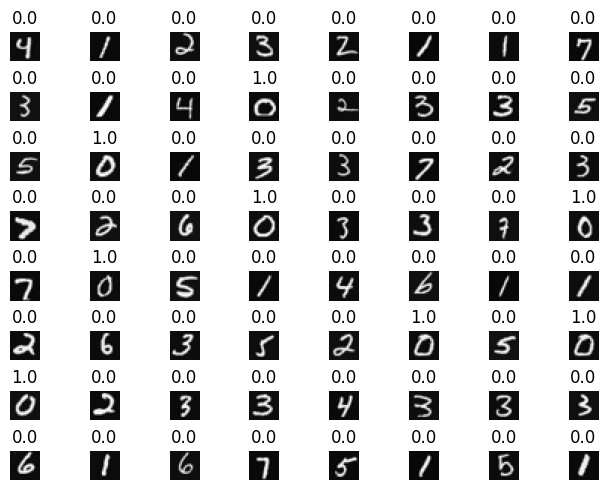

In [ ]:
fig,axes=plt.subplots(8,8)
fig.tight_layout(pad=0.1)

for i,ax in enumerate(axes.flat):
  m=np.random.randint(1,X_train.shape[0])
  x=X[m].reshape(20,20).T
  ax.imshow(x,cmap='gray')
  ax.set_title(y[m,0])
  ax.set_axis_off()

In [ ]:
# standarize the data
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
layers_dims = [10, 5, 5, 10]
k=initialise_parameters(layers_dims)

In [ ]:
for key, value in k.items():
    print(key, value.shape)

W1 (10, 5)
b1 (1, 5)
W2 (5, 5)
b2 (1, 5)
W3 (5, 10)
b3 (1, 10)


In [ ]:
f=np.zeros((1,10))
f[0][9]=1
print(f)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


<h5>Now, our dataset is ready to be used and test our neural network implementation. Let's first write multi-layer model function to implement gradient-based learning using predefined number of iterations and learning rate.
</h5>

In [ ]:
def L_layer_model(
        X, y, layers_dims,hidden_layers_activation_fn,learning_rate=0.01, num_iterations=3000,
        print_cost=True):
    """
    Implements multilayer neural network using gradient descent as the
    learning algorithm.

    Arguments
    ---------
    X : 2d-array
        data, shape: number of examples x num_px * num_px.
    y : 2d-array
        true "label" vector, shape: number of examples x 1.
    layers_dims : list
        input size and size of each layer, length: number of layers + 1.
    learning_rate : float
        learning rate of the gradient descent update rule.
    num_iterations : int
        number of iterations of the optimization loop.
    print_cost : bool
        if True, it prints the cost every 100 steps.
    hidden_layers_activation_fn : str
        activation function to be used on hidden layers: "sigmoid", "relu".

    Returns
    -------
    parameters : dict
        parameters learnt by the model. They can then be used to predict test examples.
    """
    # np.random.seed(1)

    # initialise parameters
    parameters = initialise_parameters(layers_dims)

    # initial cost list
    cost_list=[]

    for i in range(num_iterations):

        # # Stochastic Optimization
        # index=np.random.randint(1,X.shape[1])
        # print(X[index].reshape(20,20))

        # forward computation
        AL,caches=L_model_forward(X,parameters,hidden_layers_activation_fn)

        # print(AL.shape)
        # compute cost
        cost=compute_cost(AL,y)

        # print("Cost: ",cost)

        # iterate over L-layers backward to get gradients
        grads = L_model_backward(AL, y, caches, hidden_layers_activation_fn)

        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # append each 100th cost to the cost list
        if (i + 1) % 100 == 0 and print_cost:
            print(f"The cost after {i + 1} iterations is: {cost:.4f}")

        if i % 100 == 0:
            cost_list.append(cost)

    # plot the cost curve
    plt.figure(figsize=(10, 6))
    plt.plot(cost_list)
    plt.xlabel("Iterations (per hundreds)")
    plt.ylabel("Loss")
    plt.title(f"Loss curve for the learning rate = {learning_rate}")

    return parameters

def accuracy(X, parameters, y, activation_fn="relu"):
    """
    Computes the average accuracy rate.

    Arguments
    ---------
    X : 2d-array
        data, shape: number of examples x num_px * num_px * 3.
    parameters : dict
        learnt parameters.
    y : 2d-array
        true "label" vector, shape: 1 x number of examples.
    activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    accuracy : float
        accuracy rate after applying parameters on the input data
    """
    probs, caches = L_model_forward(X, parameters, activation_fn)
    labels = (probs >= 0.5) * 1
    accuracy = np.mean(labels == y) * 100

    return f"The accuracy rate is: {accuracy:.2f}%."

The cost after 100 iterations is: 3.4116
The cost after 200 iterations is: 3.2689
The cost after 300 iterations is: 3.2532
The cost after 400 iterations is: 3.2509
The cost after 500 iterations is: 3.2506
The cost after 600 iterations is: 3.2505
The cost after 700 iterations is: 3.2505
The cost after 800 iterations is: 3.2505
The cost after 900 iterations is: 3.2505
The cost after 1000 iterations is: 3.2505
The cost after 1100 iterations is: 3.2505
The cost after 1200 iterations is: 3.2505
The cost after 1300 iterations is: 3.2505
The cost after 1400 iterations is: 3.2505
The cost after 1500 iterations is: 3.2505
The cost after 1600 iterations is: 3.2505
The cost after 1700 iterations is: 3.2505
The cost after 1800 iterations is: 3.2505
The cost after 1900 iterations is: 3.2505
The cost after 2000 iterations is: 3.2505
The cost after 2100 iterations is: 3.2505
The cost after 2200 iterations is: 3.2505
The cost after 2300 iterations is: 3.2505
The cost after 2400 iterations is: 3.2505
T

'The accuracy rate is: 90.00%.'

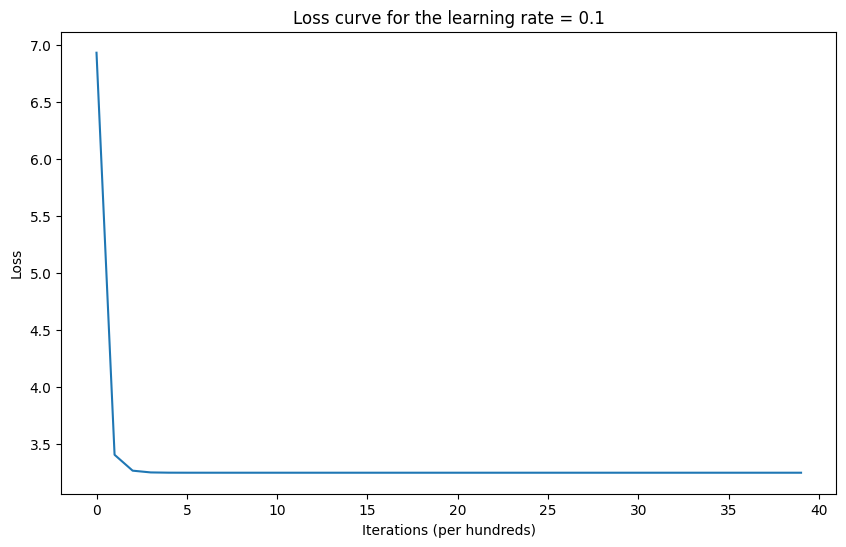

In [ ]:
# Setting layers dims
# Here dimension of each training sample is required for the intialization for  Weight matrix of each layer
# [Input hidden1 hidden2 hidden3.....hidden N Output]
layers_dims = [X_train.shape[1], 5, 5,10]

# NN with reLu activation fn for Output layer
parameters=L_layer_model(
    X_train, y_train, layers_dims,ReLu,learning_rate=0.1, num_iterations=4000)
# for key,value in parameters.items():
#   print("key: ",key,"value: ",value.shape)

# Print the accuracy
accuracy(X_test, parameters, y_test, ReLu)

<h2 style="font-family: Arial, sans-serif; color: purple;">Conclusion</h2>

<p style="font-family: Arial, sans-serif; line-height: 1.5;">In this notebook, I implemented a basic Artificial Neural Network (ANN) for recognizing handwritten digits from the MNIST dataset, using a subset of 3,750 images for training and 1,250 images for testing. The process involved several key steps:</p>

<ol style="font-family: Arial, sans-serif; line-height: 1.5;">
  <li><strong style="color: purple;">Data Preparation:</strong> We loaded a subset of the MNIST dataset, consisting of 3,750 training images and 1,250 test images of handwritten digits. These images were preprocessed to normalize the pixel values and converted into a format suitable for training the neural network.</li>
  <li><strong style="color: purple;">Model Architecture:</strong> The ANN architecture consisted of an input layer with 784 neurons (one for each pixel in the 28x28 images), a hidden layer with a variable number of neurons, and an output layer with 10 neurons corresponding to the digits 0 through 9. We used the sigmoid activation function for the hidden layer neurons and the softmax function for the output layer to obtain class probabilities.</li>
  <li><strong style="color: purple;">Training:</strong> The model was trained using gradient descent optimization. During training, forward propagation computed the output of the network for a given input, and backpropagation calculated the gradients of the loss function with respect to the parameters of the network. We updated the weights and biases of the network using these gradients to minimize the cross-entropy loss.</li>
  <li><strong style="color: purple;">Evaluation:</strong> After training the model, we evaluated its performance on a separate test set. The accuracy achieved on the test data was approximately 90%, indicating that the model can effectively classify handwritten digits.</li>
</ol>

<p style="font-family: Arial, sans-serif; line-height: 1.5; color: purple;">This project has provided valuable insights into the workings of neural networks, even with a smaller subset of the MNIST dataset. It demonstrates the importance of data preprocessing, the choice of network architecture, and the training process. Further improvements could be explored by experimenting with different architectures, optimization algorithms, and hyperparameters to potentially enhance the model's performance.</p>

<p style="font-family: Arial, sans-serif; line-height: 1.5; color: purple;">Overall, this project has served as a solid foundation for understanding and implementing neural networks for image classification tasks future exploration and refinement in the field of deep learning.</p>
